In [88]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import warnings

from contrib.handcrafted_data import syn_dataset
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineRandomShift, LineClip,
    wrap_lines_into_numpy_batch
)
from stateful_optimizer import (
    StatefulAligner, 
    LossComposition, 
    init_ot_aligner,
    make_default_loss_fn,
    make_default_optimize_fn,
    store_render_difference,
    store_transport_plan,
    strip_confidence_grads,
    save_best_batch
)
from crossing_refiner import CrossingRefinerFull

from matplotlib import pyplot as plt
plt.rc('animation', html='html5')
import matplotlib.animation as animation
from IPython.display import HTML
from geomloss import SamplesLoss
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from vectran.data.graphics_primitives import PrimitiveType
import numpy as np
import torch

torch.manual_seed(4)
np.random.seed(4)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Train a neural network for crossings inference

In [89]:
warnings.filterwarnings("ignore")
data_train = [syn_dataset[i] for i in range(20000)]
data_val = [syn_dataset[i] for i in range(20000, 30240)]

In [90]:
def make_crossing_rasters(data):
    for i, sample in enumerate(data):
        data[i]['raster'] = 1 - sample['raster']
        vectors = sample['vector'][PrimitiveType.PT_LINE]
        vectors = vectors[vectors.sum(axis=1) != 0][:, :5]
        data[i]['crossing_raster'] = SyntheticPatch.from_lines(vectors, default_line_rgba=(1., 1., 1., 0.5)).get_image()
        data[i]['crossing_raster'] /= np.max(sample['crossing_raster'])
        
    return data

data_train = make_crossing_rasters(data_train)
data_val = make_crossing_rasters(data_val)

In [91]:
model = CrossingRefinerFull().to(DEVICE)
model.train(True)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([3.0]).to(DEVICE))
mse = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dataloader_train = DataLoader(data_train, 32, True)
dataloader_val = DataLoader(data_val, 32, False)

best_val_loss = None
best_weights = None

for epoch in range(20):
    model.train(True)
    
    for batch in tqdm(dataloader_train):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        loss = criterion(pred, crossing_raster) + 0.1 * mse(pred, crossing_raster)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.train(False)
        
    avg_val_loss = 0.
    n_batches = 0
    
    for batch in tqdm(dataloader_val):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        loss = criterion(pred, crossing_raster) + 0.1 * mse(pred, crossing_raster)
        
        avg_val_loss += loss.item()
        n_batches += 1
    
    avg_val_loss /= n_batches
    best_val_loss = best_val_loss or avg_val_loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(epoch, best_val_loss)
        torch.save(model.state_dict(), 'best_crossings.pt')

  1%|          | 6/625 [00:00<00:11, 54.13it/s]

1 0.7487991556525231


  1%|          | 6/625 [00:00<00:11, 53.30it/s]

2 0.7482502026483416


  1%|          | 6/625 [00:00<00:11, 51.63it/s]

3 0.7479494718834758


  1%|          | 6/625 [00:00<00:11, 52.40it/s]

4 0.747771306335926


  1%|          | 6/625 [00:00<00:11, 52.46it/s]

6 0.7474398005753755


  1%|          | 6/625 [00:00<00:11, 53.79it/s]

9 0.74735127389431


  1%|          | 6/625 [00:00<00:11, 53.29it/s]

10 0.7472234625369311


  1%|          | 6/625 [00:00<00:11, 52.98it/s]

11 0.7470877399668098


  1%|          | 6/625 [00:00<00:11, 53.83it/s]

14 0.7469716973602771


  1%|          | 6/625 [00:00<00:11, 52.53it/s]

17 0.7469122687354683


  1%|          | 6/625 [00:00<00:12, 50.72it/s]

18 0.7468922855332494


100%|██████████| 320/320 [00:01<00:00, 195.70it/s]


In [92]:
model = CrossingRefinerFull().to(DEVICE)
model.load_state_dict(torch.load('best_crossings.pt'))
_ = model.train(False)

## Try the new aligner

In [93]:
def make_animation(image, renders):
    fig = plt.figure()
    ims = []
    for i in range(len(renders)):
        background = plt.imshow(image, animated=True, alpha=0.6, cmap='gray')
        im = plt.imshow(renders[i], animated=True, alpha=0.6)
        ims.append([background, im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    return ani

100%|██████████| 10/10 [05:58<00:00, 35.83s/it]


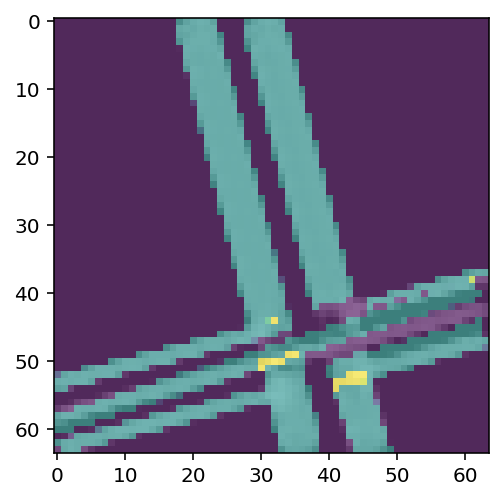

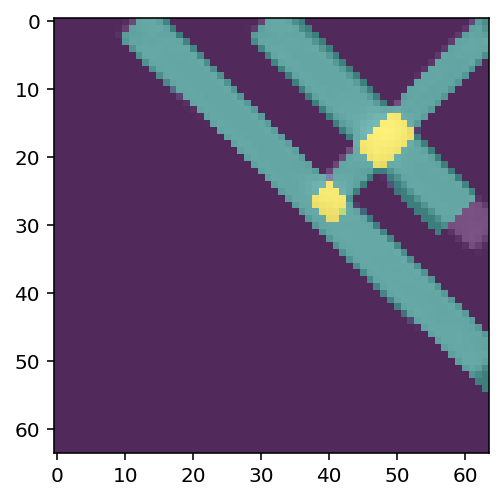

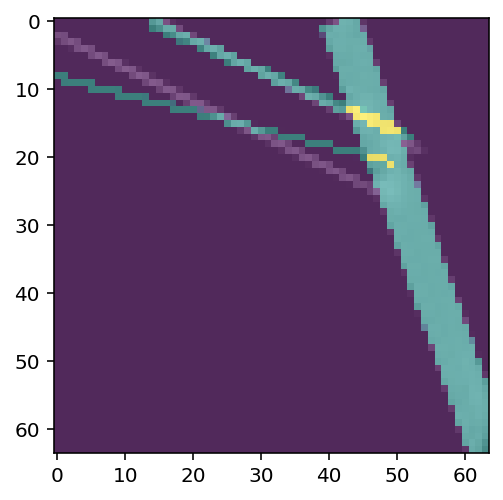

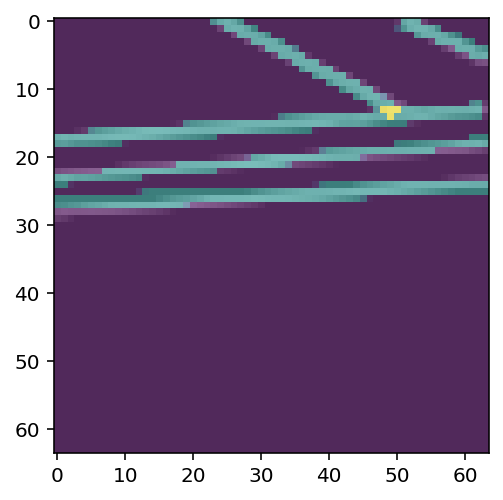

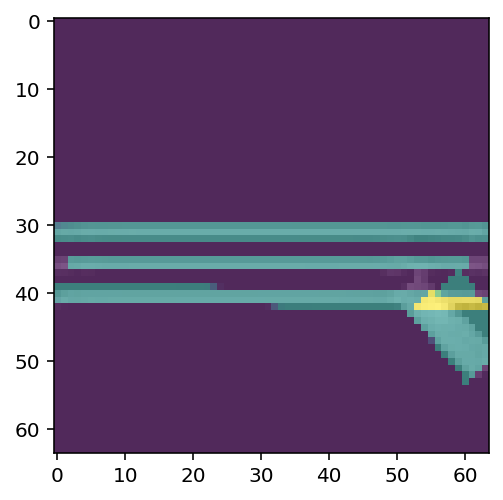

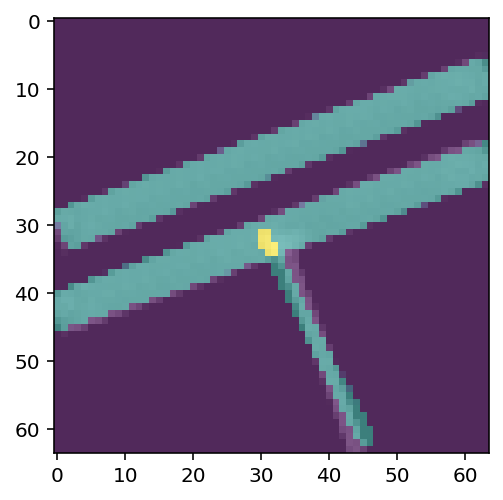

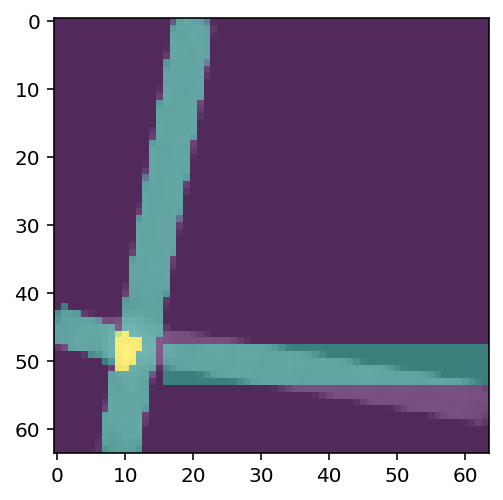

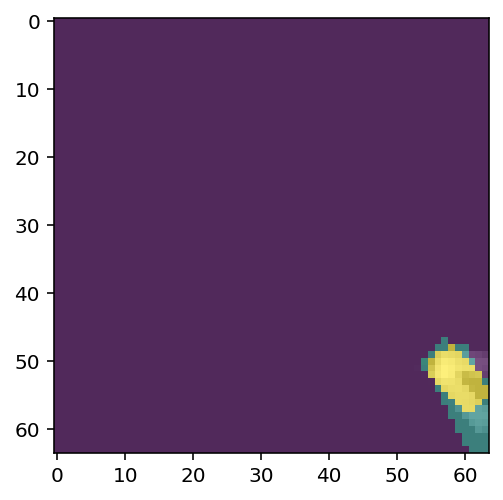

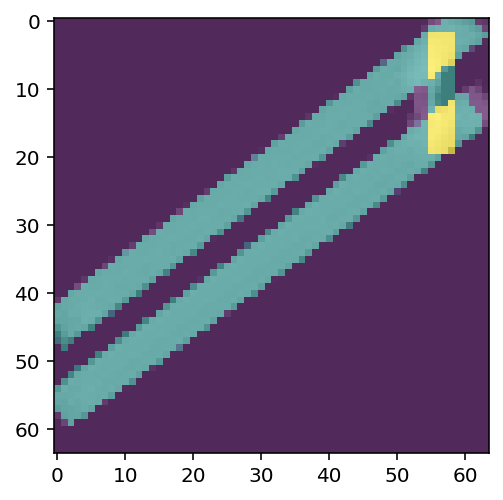

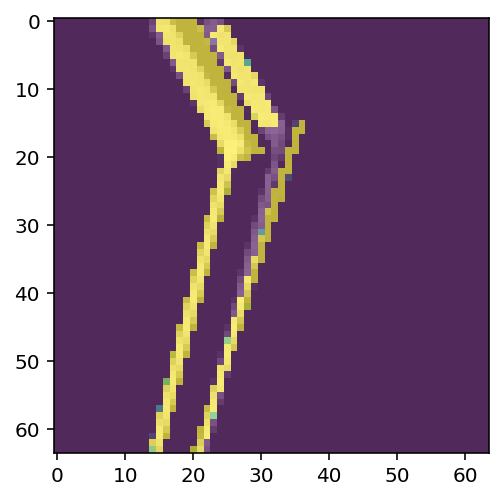

In [94]:
np.random.seed(4)
# np.random.seed(41)


def transform_synthetic_sample(sample):
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]

    perturbed_lines = perturber.transform(vectors)
    perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
    perturbed_batch = torch.from_numpy(perturbed_batch).to(DEVICE)
    
    return {
        'line_batch': perturbed_batch,
        'image': 1 - sample['raster']
    }

def accumulate_renders(state):
    if 'renders' not in state:
        state['renders'] = []
    state['renders'].append(state['render'].detach().cpu().numpy())


perturber = LinePerturbationPipe(
    LineRandomShift((-6, 6), (0, 1)),
#     LineClip(0, 63, 0, 63)  # IMPORTANT
)

def not_too_thin(state):
    return torch.sum(torch.relu(1. - state['current_line_batch'][:, :, 4]))

def bound_coordinates(padding=8.):
    def fn(state):
        line_batch = state['current_line_batch']
        return torch.sum(torch.relu(line_batch[:, :, :4] - 64. - padding)) + torch.sum(torch.relu(-padding - line_batch[:, :, :4]))
    return fn

def similar_total_mass(state):
    return torch.abs(2 * torch.sum(state['render']) - torch.sum(state['raster']))

loss = LossComposition()
loss.add(make_default_loss_fn(bce_schedule=(lambda state: 1.0)))
loss.add(not_too_thin)
# loss.add(similar_total_mass)
loss.add(bound_coordinates(8.))

aligner = None

def coords_only_grads(n_steps=200):
    def fn(state):
        strip_confidence_grads(state)
        if state['current_step'] < n_steps:
            state['current_line_batch'].grad.data[:, :, 4] = 0.
    return fn


def reduced_width_lr(multiplier=0.2):
    def fn(state):
        strip_confidence_grads(state)
        state['current_line_batch'].grad.data[:, :, 4] *= multiplier
    return fn


htmls = []

for random_seed in tqdm(range(10)):
    sample = transform_synthetic_sample(syn_dataset[random_seed])
    image = sample['image']
    # Uncomment the following two lines to use neural crossing inference
    image = torch.from_numpy(image).unsqueeze(dim=0).unsqueeze(dim=1)
    image = model.forward(image.to(DEVICE)).detach().cpu().numpy()[0][0]
    line_batch = sample['line_batch']
    
    aligner = StatefulAligner(line_batch, image)
    
    grad_transformer = reduced_width_lr(0.5)
    init_ot_aligner(aligner, loss_fn=loss,
                    optimize_fn=make_default_optimize_fn(
                        aligner, 
                        lr=0.3, 
                        transform_grads=grad_transformer,
                        base_optimizer=optim.Adam
                    ))
    
    ot_loss = SamplesLoss("sinkhorn", p=2, blur=.05, potentials=True, debias=False)
    aligner.add_callback(store_transport_plan(ot_loss))
    
    aligner.add_callback(store_render_difference)
    aligner.add_callback(save_best_batch)
    aligner.add_callback(accumulate_renders)
    
    for _ in range(300):
        aligner.step()
        
    raster = aligner.state['raster'].detach().cpu().numpy()
    anim = make_animation(raster, aligner.state['renders'])
    htmls.append(HTML(anim.to_html5_video()))

In [95]:
vc = aligner.state['vector_coords']
rc = aligner.state['raster_coords']

# vc = vc[:, 0] * 64 + vc[:, 1]
# rc = rc[:, 0] * 64 + rc[:, 1]

# vec_idx = vc[aligner.state['transport_plan'].nonzero().T[0]]
# rst_idx = rc[aligner.state['transport_plan'].nonzero().T[1]]

# transport_plan = aligner.state['transport_plan'].view(-1)

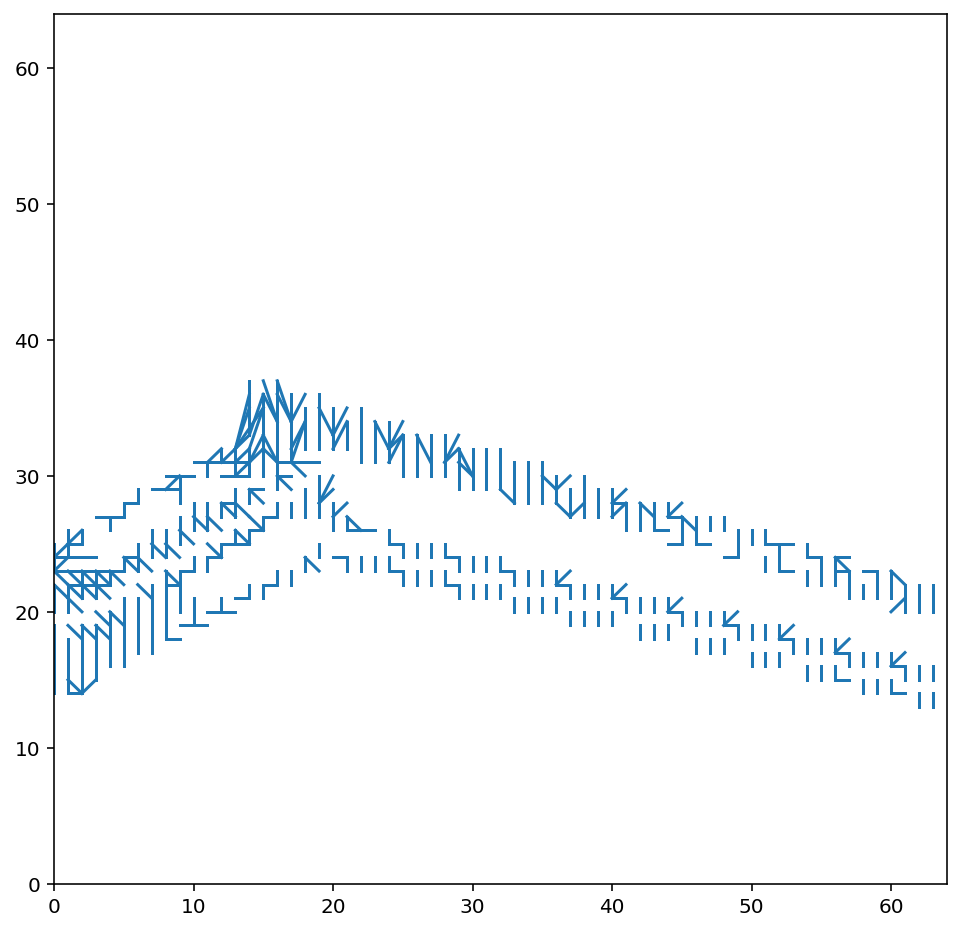

In [96]:
transport_plan = aligner.state['transport_plan']

plt.figure(figsize=(8, 8))
plt.xlim(0, 64)
plt.ylim(0, 64)

max_transported = transport_plan.max().item()

for coords in transport_plan.nonzero():
    i = coords[0].item()
    j = coords[1].item()
    
    start = vc[i].detach().cpu().numpy()
    end = rc[j].detach().cpu().numpy()
    weight = transport_plan[i][j]
    
    plt.plot([start[0], end[0]], [start[1], end[1]], color='C0')
    
plt.show()

In [97]:
htmls[0]

In [98]:
htmls[1]

In [99]:
htmls[2]

In [100]:
htmls[3]

In [101]:
htmls[4]

In [102]:
htmls[5]

In [103]:
htmls[6]

In [104]:
htmls[7]

In [105]:
htmls[8]

In [106]:
htmls[9]